In [28]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [37]:
df_csv = "./output/df20_pred_lastname.csv"
cands_csv = "./data/CampaignFin20/cands20.txt"

In [3]:
lf = (
        pl.scan_csv(
            df_csv,
            has_header=True,
            ignore_errors=True
        )
    )

In [4]:
df = lf.collect()
print(df.head(10))

shape: (10, 22)
┌────────┬─────────────┬─────────────┬────────────┬───┬───────────┬──────────┬────────────┬────────┐
│ dummy1 ┆ dummy2      ┆ contrib_id  ┆ name       ┆ … ┆ firstname ┆ lastname ┆ name_new   ┆ ethnic │
│ ---    ┆ ---         ┆ ---         ┆ ---        ┆   ┆ ---       ┆ ---      ┆ ---        ┆ ---    │
│ i64    ┆ i64         ┆ str         ┆ str        ┆   ┆ str       ┆ str      ┆ str        ┆ str    │
╞════════╪═════════════╪═════════════╪════════════╪═══╪═══════════╪══════════╪════════════╪════════╡
│ 2020   ┆ 40302202012 ┆ p0004869853 ┆ LONNBERG,  ┆ … ┆ carl      ┆ lonnberg ┆ carl       ┆ not    │
│        ┆ 14334986    ┆             ┆ CARL       ┆   ┆           ┆          ┆ lonnberg   ┆        │
│ 2020   ┆ 40302202012 ┆ k0001516259 ┆ LOVO,      ┆ … ┆ mario     ┆ lovo     ┆ mario lovo ┆ not    │
│        ┆ 14334988    ┆             ┆ MARIO      ┆   ┆           ┆          ┆            ┆        │
│ 2020   ┆ 40302202012 ┆ h3003526289 ┆ LOGUE,     ┆ … ┆ katherine ┆ logue  

In [5]:
print(df.columns)

['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 'orgname', 'ultorg', 'realcode', 'amount', 'street', 'city', 'state', 'zip', 'recipcode', 'type', 'gender', 'occupation', 'employer', 'firstname', 'lastname', 'name_new', 'ethnic']


In [6]:
print(df["state"].value_counts().sort(by="count", descending=True))

shape: (95, 2)
┌───────┬─────────┐
│ state ┆ count   │
│ ---   ┆ ---     │
│ str   ┆ u32     │
╞═══════╪═════════╡
│ CA    ┆ 5770396 │
│ TX    ┆ 2630388 │
│ NY    ┆ 2453987 │
│ FL    ┆ 2158017 │
│ PA    ┆ 1266349 │
│ …     ┆ …       │
│ SE    ┆ 1       │
│ BS    ┆ 1       │
│ NT    ┆ 1       │
│ OF    ┆ 1       │
│ RM    ┆ 1       │
└───────┴─────────┘


In [7]:
print(df.filter(pl.col("ethnic") == "ind")["name_new"].value_counts().sort(by="count", descending=True))

shape: (21_737, 2)
┌──────────────────┬───────┐
│ name_new         ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ monique adam     ┆ 2036  │
│ stephen hayden   ┆ 1796  │
│ jean nandi       ┆ 944   │
│ margaret j reddy ┆ 924   │
│ erica chahal     ┆ 905   │
│ …                ┆ …     │
│ nadim m saab     ┆ 1     │
│ shyam parekh     ┆ 1     │
│ harsha rao       ┆ 1     │
│ gary rana        ┆ 1     │
│ kavita puri      ┆ 1     │
└──────────────────┴───────┘


In [8]:
print(df.filter(pl.col("ethnic") == "not")["amount"].mean())
print(df.filter(pl.col("ethnic") == "ind")["amount"].mean())

343.5191923862918
570.84480206023


In [9]:
print(df.filter(pl.col("ethnic") == "not")["amount"].median())
print(df.filter(pl.col("ethnic") == "ind")["amount"].median())

35.0
50.0


In [10]:
amounts_all = df["amount"].to_list()
amounts_indian = df.filter(pl.col("ethnic") == "ind")["amount"].to_list()
amounts_non_indian = df.filter(pl.col("ethnic") == "not")["amount"].to_list()

In [11]:
region_mapping = {
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "NJ": "Northeast", "NY": "Northeast", "PA": "Northeast", "RI": "Northeast", "VT": "Northeast",
    
    "IL": "Midwest", "IN": "Midwest", "IA": "Midwest", "KS": "Midwest", "MI": "Midwest",
    "MN": "Midwest", "MO": "Midwest", "NE": "Midwest", "ND": "Midwest", "OH": "Midwest",
    "SD": "Midwest", "WI": "Midwest",
    
    "AL": "South", "AR": "South", "DE": "South", "FL": "South", "GA": "South",
    "KY": "South", "LA": "South", "MD": "South", "MS": "South", "NC": "South",
    "OK": "South", "SC": "South", "TN": "South", "TX": "South", "VA": "South", "WV": "South",
    
    "AK": "West", "AZ": "West", "CA": "West", "CO": "West", "HI": "West",
    "ID": "West", "MT": "West", "NV": "West", "NM": "West", "OR": "West",
    "UT": "West", "WA": "West", "WY": "West"
}

df = df.with_columns(pl.col("state").replace(region_mapping).alias("region"))

In [12]:
census_region_mapping = {
    "CT": "New England", "ME": "New England", "MA": "New England", 
    "NH": "New England", "RI": "New England", "VT": "New England",
    "NJ": "Mid-Atlantic", "NY": "Mid-Atlantic", "PA": "Mid-Atlantic",

    "IL": "Great Lakes", "IN": "Great Lakes", "MI": "Great Lakes", 
    "OH": "Great Lakes", "WI": "Great Lakes",
    "IA": "Plains", "KS": "Plains", "MN": "Plains", 
    "MO": "Plains", "NE": "Plains", "ND": "Plains", "SD": "Plains",

    "DE": "South Atlantic", "FL": "South Atlantic", "GA": "South Atlantic", 
    "MD": "South Atlantic", "NC": "South Atlantic", "SC": "South Atlantic", 
    "VA": "South Atlantic", "WV": "South Atlantic", "DC": "South Atlantic",
    "AL": "Deep South", "KY": "Deep South", "MS": "Deep South", "TN": "Deep South",
    "AR": "Gulf Coast", "LA": "Gulf Coast", "OK": "Gulf Coast", "TX": "Gulf Coast",

    "AZ": "Mountain West", "CO": "Mountain West", "ID": "Mountain West", 
    "MT": "Mountain West", "NV": "Mountain West", "NM": "Mountain West", 
    "UT": "Mountain West", "WY": "Mountain West",
    "AK": "Pacific", "CA": "Pacific", "HI": "Pacific", 
    "OR": "Pacific", "WA": "Pacific"
}

df = df.with_columns(pl.col("state").replace(census_region_mapping).alias("census_region"))

In [13]:
amounts = []
regions = list(dict.fromkeys(region_mapping.values()))

amounts.append(df["amount"].to_list())
for region in regions:
    amounts.append(df.filter(pl.col("region") == region)["amount"].to_list())

In [14]:
census_amounts = []
census_regions = list(dict.fromkeys(census_region_mapping.values()))

census_amounts.append(df["amount"].to_list())
for census_region in census_regions:
    census_amounts.append(df.filter(pl.col("census_region") == census_region)["amount"].to_list())

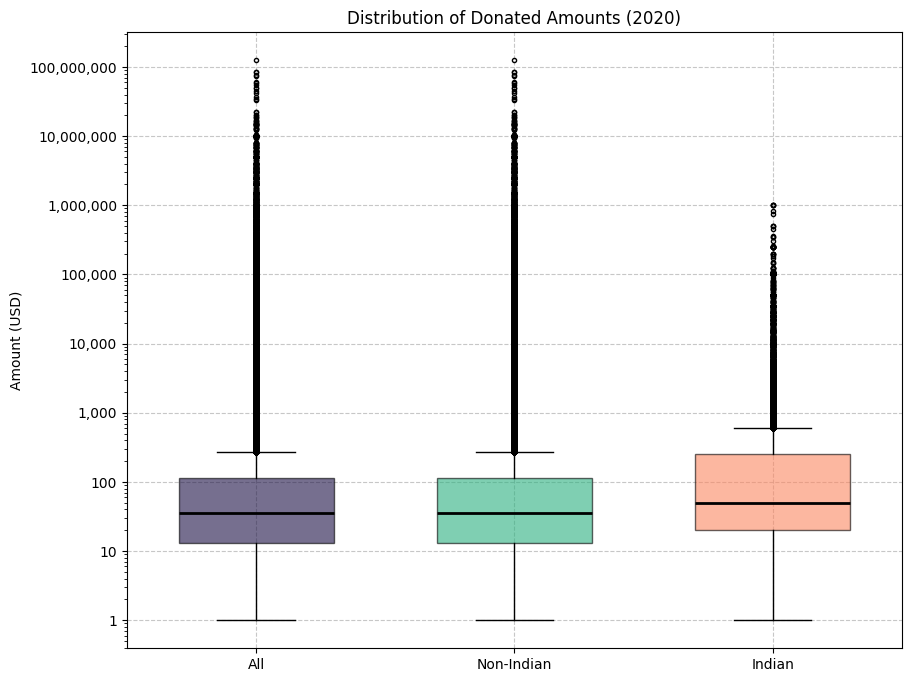

In [15]:
plt.figure(figsize=(10, 8))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], tick_labels=["All", "Non-Indian", "Indian"], patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

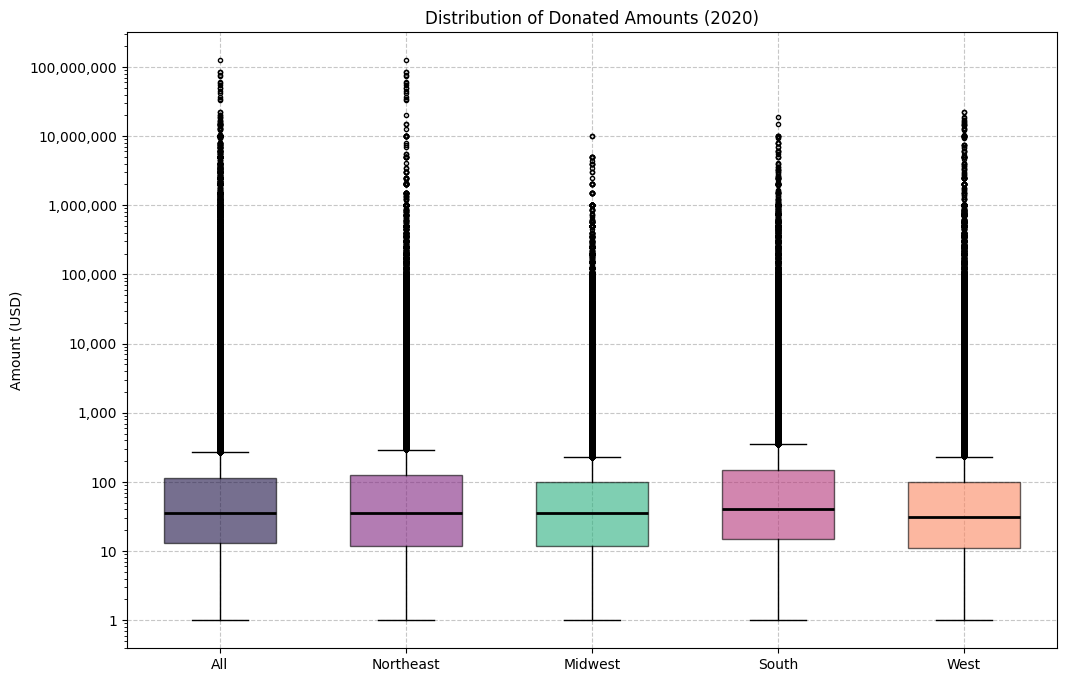

In [16]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(amounts, tick_labels=["All"] + regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#812581", "#2ab07f", "#b5367a", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

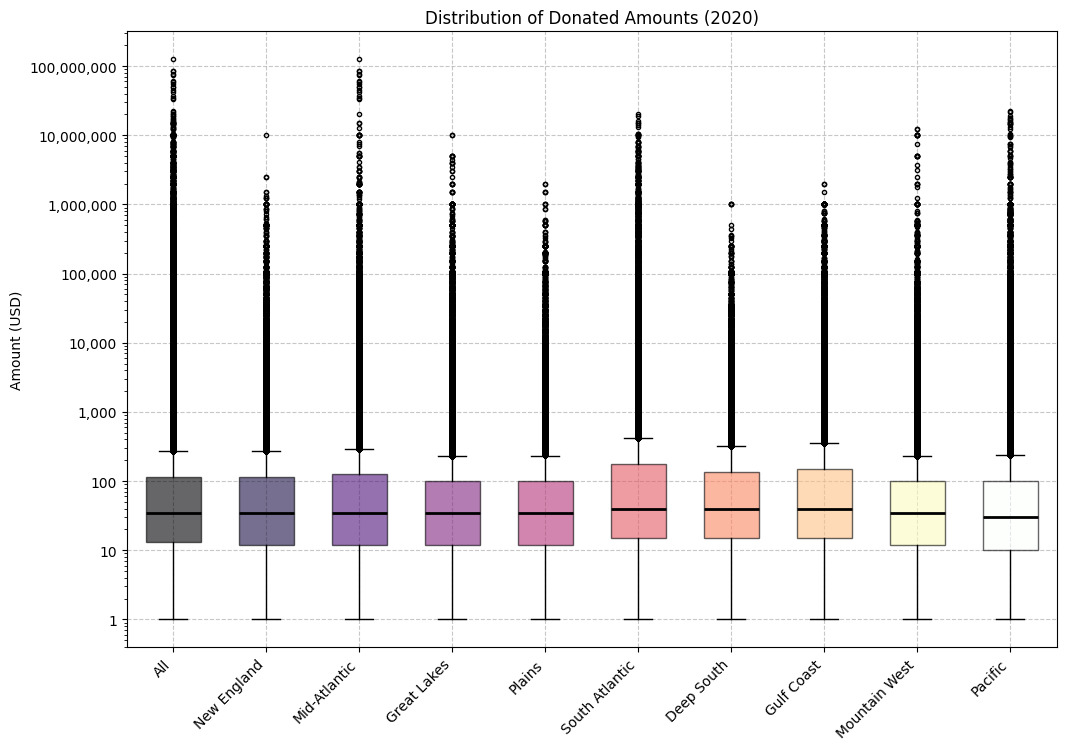

In [17]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [18]:
state_stats = (
    df.group_by("state")
    .agg(
        pl.col("amount").mean().alias("avg_amount"),
        pl.col("amount").median().alias("med_amount"),
        pl.col("amount").count().alias("total_donations"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").mean().alias("avg_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").median().alias("med_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").count().alias("indian_donations")
    )
    .sort("avg_amount", descending=True)
)

In [19]:
df.filter(pl.col("state") == "TA")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4032820201718323278,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""
2020,4032820201718323280,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""


In [20]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""PA""",201.065893,37.0,1266349,492.952629,50.0,5383
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916
"""MA""",319.88028,35.0,1138194,664.219606,58.0,5692


In [21]:
state_stats.write_csv("./output/df20_state_stats.csv")

In [22]:
import geopandas as gpd

# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats.to_pandas(), on="state", how="left")

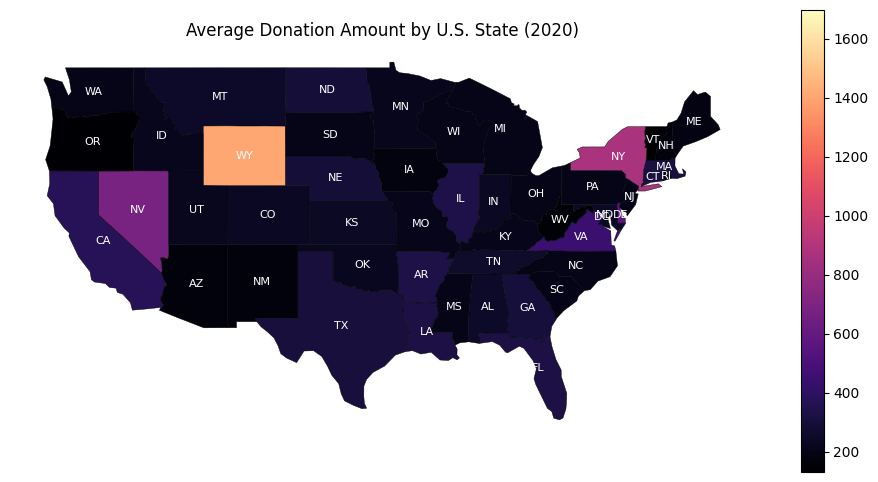

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [24]:
state_stats.sort(by="avg_amount", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
"""WY""",1408.825765,50.0,59058,4650.695652,1000.0,46
"""MH""",1166.5,1166.5,2,null,null,0
"""TA""",1000.0,1000.0,2,null,null,0
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""NT""",750.0,750.0,1,null,null,0
"""NV""",678.058047,35.0,322310,3214.073323,250.0,641
"""99""",668.40625,250.0,32,null,null,0
""" """,664.685329,75.0,9502,1981.357143,714.0,56


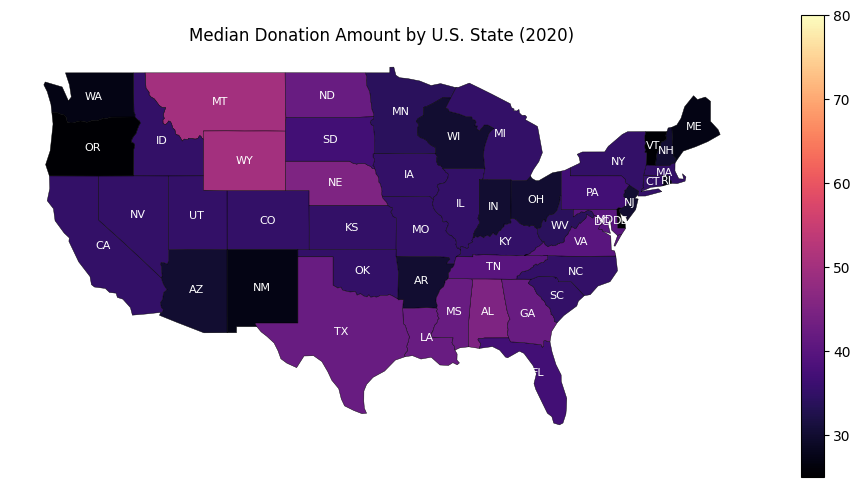

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [26]:
state_stats.sort(by="med_amount", descending=True)[20:30]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""EN""",202.0,175.0,6,null,null,0
"""HO""",211.4,150.0,5,null,null,0
"""TE""",133.333333,100.0,3,null,null,0
"""TY""",100.0,100.0,2,null,null,0
"""TO""",87.8,100.0,30,null,null,0
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
""" """,664.685329,75.0,9502,1981.357143,714.0,56
"""PW""",136.117647,60.0,17,null,null,0
"""WY""",1408.825765,50.0,59058,4650.695652,1000.0,46


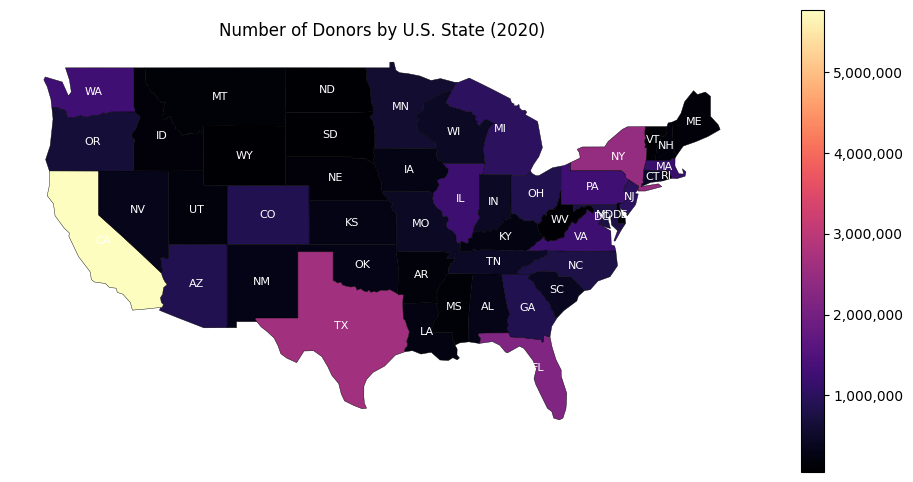

In [29]:
# import funcformatter


fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="total_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [30]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""PA""",201.065893,37.0,1266349,492.952629,50.0,5383
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916
"""MA""",319.88028,35.0,1138194,664.219606,58.0,5692


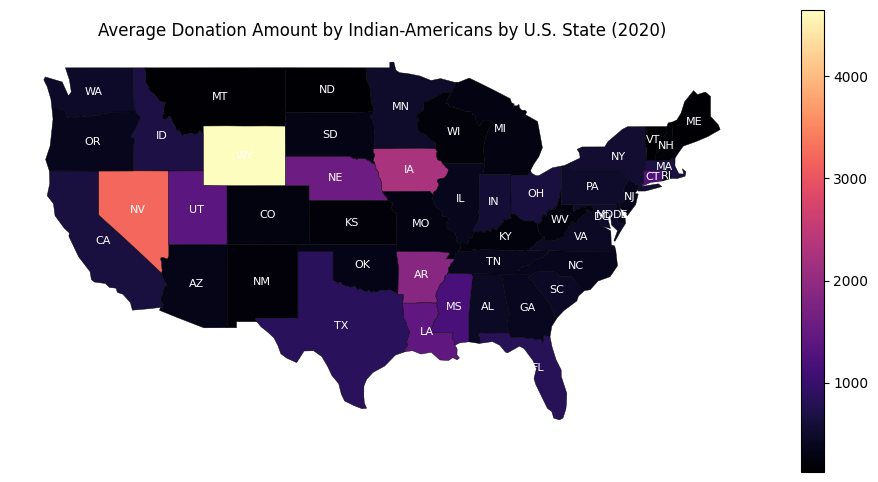

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [32]:
state_stats.sort(by="avg_amount_indian", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""MH""",1166.5,1166.5,2,null,null,0
"""TA""",1000.0,1000.0,2,null,null,0
"""NT""",750.0,750.0,1,null,null,0
"""99""",668.40625,250.0,32,null,null,0
"""IR""",637.162162,500.0,74,null,null,0
"""MB""",578.857143,300.0,7,null,null,0
"""QC""",552.412698,333.0,63,null,null,0
"""FM""",522.333333,437.5,6,null,null,0
"""RM""",500.0,500.0,1,null,null,0


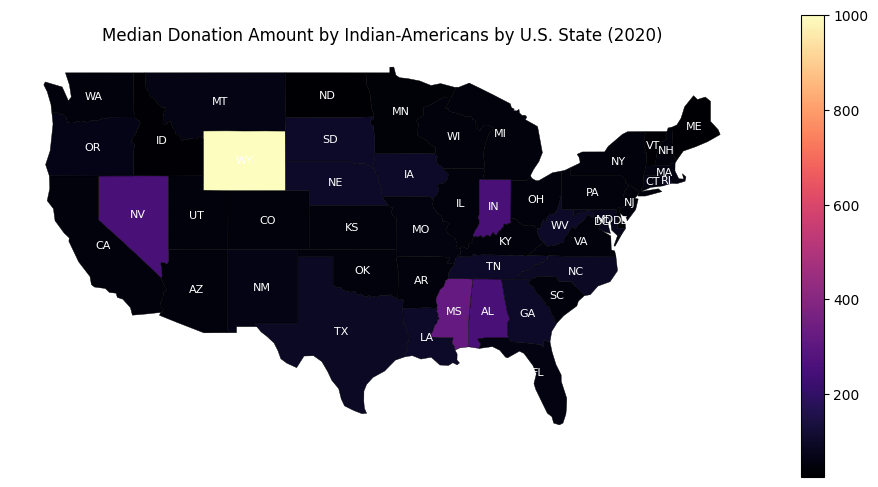

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [34]:
state_stats.sort(by="med_amount_indian", descending=True)[39:49]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""ON""",344.344828,250.0,290,350.0,350.0,1
"""MS""",199.731586,42.0,129833,1201.137615,314.5,218
"""NV""",678.058047,35.0,322310,3214.073323,250.0,641
"""VI""",349.068306,50.0,3660,165.571429,250.0,21
"""AL""",252.331034,45.0,298329,432.314488,250.0,566
"""IN""",231.419031,30.0,441812,581.054086,250.0,1701
"""RI""",178.555251,27.0,113970,359.623932,103.0,234
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
"""LA""",325.451679,42.0,251393,1447.076825,100.0,781


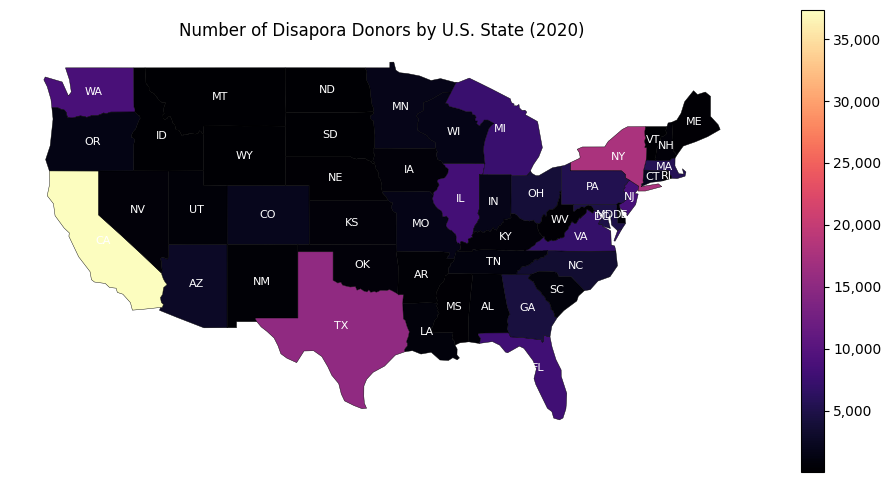

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="indian_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Disapora Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [36]:
state_stats.sort(by="indian_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""NJ""",193.451852,30.0,1000117,369.145122,50.0,8517
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""MI""",199.119385,35.0,993046,273.709279,50.0,7361
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916


In [38]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'])
    )
cands = cands_lf.collect()
print(cands.head(10))

shape: (10, 11)
┌───────────┬───────────┬──────────────────────┬───────┬───┬────────┬────────┬────────┬────────┐
│ id        ┆ recip_id  ┆ name                 ┆ party ┆ … ┆ dummy6 ┆ dummy7 ┆ dummy8 ┆ dummy9 │
│ ---       ┆ ---       ┆ ---                  ┆ ---   ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str       ┆ str       ┆ str                  ┆ str   ┆   ┆ str    ┆ str    ┆ str    ┆ str    │
╞═══════════╪═══════════╪══════════════════════╪═══════╪═══╪════════╪════════╪════════╪════════╡
│ H0AK00105 ┆ N00039029 ┆ Thomas Lamb (I)      ┆ I     ┆ … ┆ Y      ┆ C      ┆ 3N     ┆        │
│ H0AK00113 ┆ N00047445 ┆ Ray Sean Tugatuk (D) ┆ D     ┆ … ┆ Y      ┆ C      ┆ DL     ┆        │
│ H0AK01046 ┆ N00047447 ┆ Thomas Catalano (3)  ┆ 3     ┆ … ┆        ┆        ┆ 3N     ┆        │
│ H0AL01055 ┆ N00044245 ┆ Jerry Carl (R)       ┆ R     ┆ … ┆ Y      ┆ O      ┆ RW     ┆        │
│ H0AL01063 ┆ N00044288 ┆ Wes Lambert (R)      ┆ R     ┆ … ┆ Y      ┆ O      ┆ RL     ┆        │
│ H0AL01071 ┆ 

In [40]:
df.filter(pl.col("recip_id") == "N00044839").head(5)

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4030220201222914336,"""r0017002134 ""","""PETTIFORD, HELEN""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""RALEIGH""","""NC""",27604.0,"""DL""","""24T""","""F""","""TEACHER""","""THE MAGELLAN CHARTER SCHOOL""","""helen""","""pettiford""","""helen pettiford""","""not""","""South""","""South Atlantic"""
2020,4030220201223662421,"""r0019074362 ""","""OLIVENCIA-SIMMONS, IVELISSE""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""CHARLOTTE""","""NC""",28277.0,"""DL""","""24T""","""F""","""NOT EMPLOYED""","""NOT EMPLOYED""","""ivelisse""","""olivencia-simmons""","""ivelisse olivencia-simmons""","""not""","""South""","""South Atlantic"""
2020,4030220201223647042,"""r0001569100 ""","""LEMMON, CHRIS""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOSELEY""","""VA""",23120.0,"""DL""","""24T""","""M""","""PROFESSOR""","""VCU""","""chris""","""lemmon""","""chris lemmon""","""not""","""South""","""South Atlantic"""
2020,4030220201214499368,"""m0001668516 ""","""LAMBERT, PHILLIP""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOBILE""","""AL""",36608.0,"""DL""","""24T""","""M""","""SUPERVISOR""","""STATE OF AL DDS""","""phillip""","""lambert""","""phillip lambert""","""not""","""South""","""Deep South"""
2020,4032420201713973997,"""p0003376821 ""","""VOIT, LAWRENCE""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOBILE""","""AL""",36609.0,"""DL""","""24T""","""M""","""ATTORNEY""","""SILVER VOIT & THOMPSON""","""lawrence""","""voit""","""lawrence voit""","""not""","""South""","""Deep South"""


In [42]:
recipients_indian_dons = df.filter(pl.col("ethnic") == "ind")["recip_id"].to_list()
cands_indian_donors = cands.filter(pl.col("recip_id").is_in(recipients_indian_dons))
cands_indian_donors.head(5)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9
str,str,str,str,str,str,str,str,str,str,str
"""H0AL01055""","""N00044245""","""Jerry Carl (R)""","""R""","""AL01""",""" ""","""Y""","""Y""","""O""","""RW""",""" """
"""H0AL01089""","""N00044482""","""Bill Hightower (R)""","""R""","""AL01""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02145""","""N00045203""","""Jeff Coleman (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02152""","""N00045204""","""Troy King (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02178""","""N00045630""","""Jessica Taylor (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """


In [44]:
cands_indian_donors["party"].value_counts().sort(by="count", descending=True)

party,count
str,u32
"""D""",647
"""R""",503
"""I""",9
"""L""",6
"""3""",4


In [46]:
cands_indian_donors["dummy8"].value_counts().sort(by="count", descending=True)

dummy8,count
str,u32
"""DL""",307
"""DW""",238
"""RL""",210
"""RW""",202
"""RI""",51
…,…
"""RO""",3
"""RC""",3
"""DO""",3


In [48]:
donations = (
    df.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts = cands.join(donations, on="recip_id", how="left").fill_null(0)
receipts = receipts.sort("total_amount", descending=True)
receipts[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.0866e9,1243
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,6.81837529e8,3013570
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,4.76382132e8,1709576
"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,3.2024946e8,5271
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.12206545e8,2552483
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.12206545e8,2552483
"""P00010298""","""N00044183""","""Pete Buttigieg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,8.9972238e7,643304
"""H8GA06195""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,7.4541119e7,165709
"""S8GA00180""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,7.4541119e7,165709


In [49]:
df_indian = df.filter(pl.col("ethnic") == "ind")

donations_indian = (
    df_indian.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts_indian = cands.join(donations_indian, on="recip_id", how="left").fill_null(0)
receipts_indian = receipts_indian.sort("total_amount", descending=True)
receipts_indian[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,5.801522e6,17519
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,2.085394e6,5761
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499
"""H8NY12129""","""N00041983""","""Suraj Patel (D)""","""D""","""NY12""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.370702e6,707
"""H0CT03155""","""N00046167""","""Margaret Streicker (R)""","""R""","""CT03""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,1.266779e6,10
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115
"""H6IL08147""","""N00033240""","""Raja Krishnamoorthi (D)""","""D""","""IL08""","""IL08""","""Y""","""Y""","""I""","""DW""",""" """,1.105347e6,1170


In [50]:
print(receipts["total_amount"].sum())
print(receipts_indian["total_amount"].sum())

5825289000.0
47547372.0


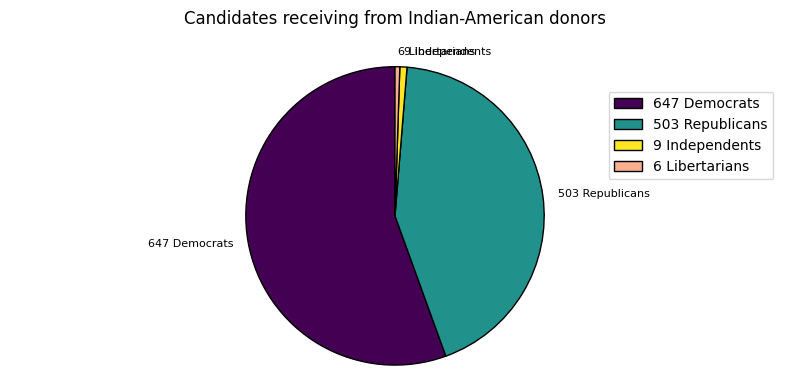

In [45]:
labels = ['647 Democrats', '503 Republicans', '9 Independents', '6 Libertarians']
sizes = [647, 503, 9, 6]

plt.figure(figsize=(8, 4))
plt.pie(sizes, 
        labels=labels, 
        colors=["#440154", "#21918c", "#fde725", "#fcae91"],
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 8})

plt.title('Candidates receiving from Indian-American donors', pad=20, fontsize=12)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [51]:
receipts_merged = receipts_indian.join(
    receipts.select(["recip_id", "total_amount"]),
    on="recip_id",
    how="inner"
)

receipts_merged = receipts_merged.with_columns(
    (pl.col("total_amount") / 
    pl.col("total_amount_right") * 100)
    .alias("pct_share")
)

receipts_merged.head(10)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,576.0,5,1.0866e9,0.000053
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,5.801522e6,17519,6.81837529e8,0.850866
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,2.085394e6,5761,4.76382132e8,0.437757
"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,22521.0,23,3.2024946e8,0.007032
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""P00010298""","""N00044183""","""Pete Buttigieg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,653534.0,2161,8.9972238e7,0.726373


In [52]:
top_shares = receipts_merged.filter((pl.col("pct_share").is_not_null()) & 
                        (pl.col("pct_share").is_not_nan())
    ).sort(
    pl.col("pct_share"), 
    descending=True
)
top_shares[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H8CA48084""","""N00041312""","""Omar Siddiqui (D)""","""D""","""CA48""",""" """,""" """,""" """,""" ""","""DN""",""" """,12000.0,1,12000.0,100.0
"""H0NY05088""","""N00045266""","""Amit Lal (I)""","""I""","""NY05""",""" ""","""Y""","""Y""","""C""","""3L""",""" """,5200.0,1,5200.0,100.0
"""H0CA47158""","""N00045220""","""Shawn Roshan (D)""","""D""","""CA47""",""" """,""" ""","""Y""","""C""","""DN""",""" """,1000.0,2,1000.0,100.0
"""P60008075""","""N00009954""","""Lincoln Chafee (D)""","""D""","""PRES""",""" """,""" """,""" """,""" ""","""DN""",""" """,80000.0,3,80750.0,99.071207
"""H0NC04204""","""N00046241""","""Debesh Sarkar (R)""","""R""","""NC04""",""" """,""" ""","""Y""","""C""","""RL""",""" """,6490.0,4,6740.0,96.290801
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115,1.514535e6,80.741284
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115,1.514535e6,80.741284
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115,1.514535e6,80.741284
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115,1.514535e6,80.741284


In [60]:
top_shares[40:50]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H8PA07135""","""N00041179""","""Joe Billie (R)""","""R""","""PA05""",""" """,""" """,""" """,""" ""","""RN""",""" """,239.0,1,1639.0,14.582062
"""H6TX24149""","""N00038290""","""Jan McDowell (D)""","""D""","""TX24""",""" """,""" ""","""Y""","""O""","""DL""",""" """,10000.0,3,74272.0,13.464024
"""H0NY04123""","""N00046428""","""Steve Raiser (R)""","""R""","""NY04""",""" """,""" ""","""Y""","""C""","""RN""",""" """,2800.0,1,20950.0,13.365155
"""H0VA07117""","""N00045174""","""Jason Roberge (R)""","""R""","""VA07""",""" """,""" ""","""Y""","""C""","""RL""",""" """,500.0,2,3750.0,13.333333
"""H4TX18054""","""N00005818""","""Sheila Jackson Lee (D)""","""D""","""TX18""","""TX18""","""Y""","""Y""","""I""","""DW""",""" """,113350.0,82,918772.0,12.33712
"""H4CA12055""","""N00026427""","""Ro Khanna (D)""","""D""","""CA17""","""CA17""","""Y""","""Y""","""I""","""DW""",""" """,413214.0,263,3.48608e6,11.853256
"""H8NJ02216""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJ02""",""" """,""" """,""" ""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253
"""S0NJ00191""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJS2""",""" """,""" ""","""Y""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253
"""S8NJ00483""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJS2""",""" """,""" """,""" ""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253


In [56]:
df.filter(pl.col("recip_id") == "N00009954")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4042120201737543451,"""q0000685909 ""","""AMUNDSON, NATHAN""","""N00009954""","""Wisconsin Moss Co""",null,"""Y4000""",250.0,null,"""BABCOCK""","""WI""",54413.0,"""DN""","""15 ""","""M""","""FARMER""","""WISCONSIN MOSS COMPANY""","""nathan""","""amundson""","""nathan amundson""","""not""","""Midwest""","""Great Lakes"""
2020,4042120201737543452,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",20000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
2020,4022620201694293328,"""r00022804431""","""CASTALDO, RICHARD""","""N00009954""","""Gallup Indian Climic""",null,"""Y4000""",250.0,null,"""GALLUP""","""NM""",87301.0,"""DN""","""15 ""","""M""",null,null,"""richard""","""castaldo""","""richard castaldo""","""not""","""West""","""Mountain West"""
2020,4022620201694293329,"""h30011861551""","""SINGER, DANIEL""","""N00009954""","""Robison Oil""",null,"""E1100""",250.0,null,"""BRIARCLIFF MANOR""","""NY""",10510.0,"""DN""","""15 ""","""M""","""EXECUTIVE""","""ROBISON OIL""","""daniel""","""singer""","""daniel singer""","""not""","""Northeast""","""Mid-Atlantic"""
2020,4022620201694293331,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",10000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
2020,4022620201694293332,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",50000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
